In [7]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

# Machine learning related imports
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    mean_squared_error, r2_score, classification_report,
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score
)

# Import models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
import xgboost as xgb

# Configure warnings and display options
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Load the dataset
df = pd.read_csv("10k_diabetes (1).csv")

# Display basic information
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

Dataset Shape: (10000, 51)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      10000 non-null  object
 1   gender                    10000 non-null  object
 2   age                       10000 non-null  object
 3   weight                    10000 non-null  object
 4   admission_type_id         9279 non-null   object
 5   discharge_disposition_id  9531 non-null   object
 6   admission_source_id       9064 non-null   object
 7   time_in_hospital          10000 non-null  int64 
 8   payer_code                10000 non-null  object
 9   medical_specialty         10000 non-null  object
 10  num_lab_procedures        10000 non-null  int64 
 11  num_procedures            10000 non-null  int64 
 12  num_medications           10000 non-null  int64 
 13  number_outpatient         10000 non

In [8]:
# Replace '?' with 'Unknown' for categorical variables
df['weight'] = df['weight'].replace('?', 'Unknown')
df['medical_specialty'] = df['medical_specialty'].replace('?', 'Unknown')
df['payer_code'] = df['payer_code'].replace("?", 'Unknown')

# Fill missing admission types with mode
df['admission_type_id'] = df['admission_type_id'].fillna(df['admission_type_id'].mode()[0])
df['admission_source_id'] = df['admission_source_id'].fillna(df['admission_source_id'].mode()[0])

# Convert age ranges to numeric midpoints
def age_to_midpoint(age_range):
    if pd.isna(age_range) or age_range == '?':
        return None
    nums = [int(x) for x in age_range.strip('[]()').split('-')]
    return sum(nums) / 2

df['age_numeric'] = df['age'].apply(age_to_midpoint)

# Verify changes
print("Unique values in weight column:", df['weight'].unique())
print("\nUnique values in age_numeric:", df['age_numeric'].unique())

Unique values in weight column: ['Unknown' '[50-75)' '[75-100)' '[100-125)' '[150-175)' '[0-25)'
 '[125-150)' '[25-50)']

Unique values in age_numeric: [55. 25. 85. 75. 65. 35. 45. 15. 95.  5.]


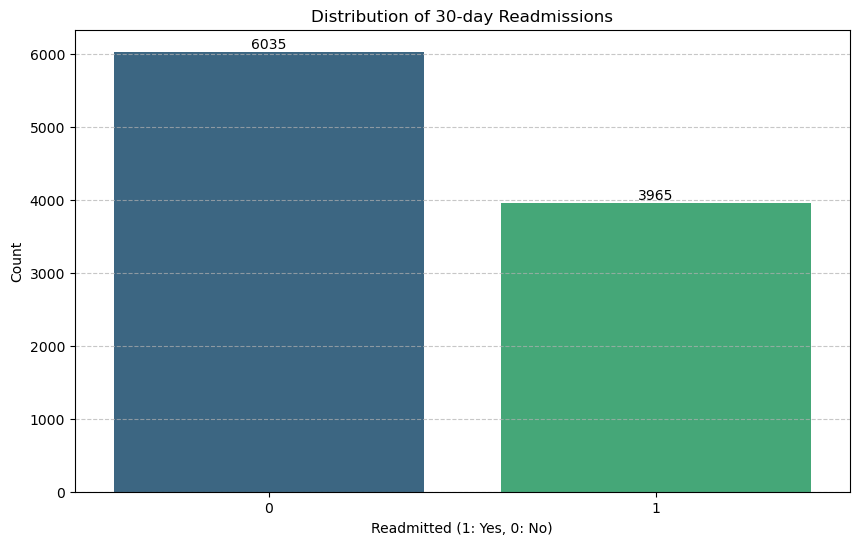


Readmission Rate: 39.65%

Detailed Statistics:
--------------------------------------------------
Total patients: 10000
Number of readmissions: 3965
Number of non-readmissions: 6035


In [9]:
# Create binary readmission target
df['readmitted_30'] = df['readmitted'].astype(int)

# Visualize readmission distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='readmitted_30', palette='viridis')
plt.title('Distribution of 30-day Readmissions')
plt.xlabel('Readmitted (1: Yes, 0: No)')
plt.ylabel('Count')

# Add value labels on top of each bar
for i in plt.gca().containers:
    plt.gca().bar_label(i)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print readmission statistics
readmission_rate = df['readmitted_30'].mean() * 100
print(f"\nReadmission Rate: {readmission_rate:.2f}%")
print("\nDetailed Statistics:")
print("-" * 50)
print("Total patients:", len(df))
print("Number of readmissions:", df['readmitted_30'].sum())
print("Number of non-readmissions:", len(df) - df['readmitted_30'].sum())

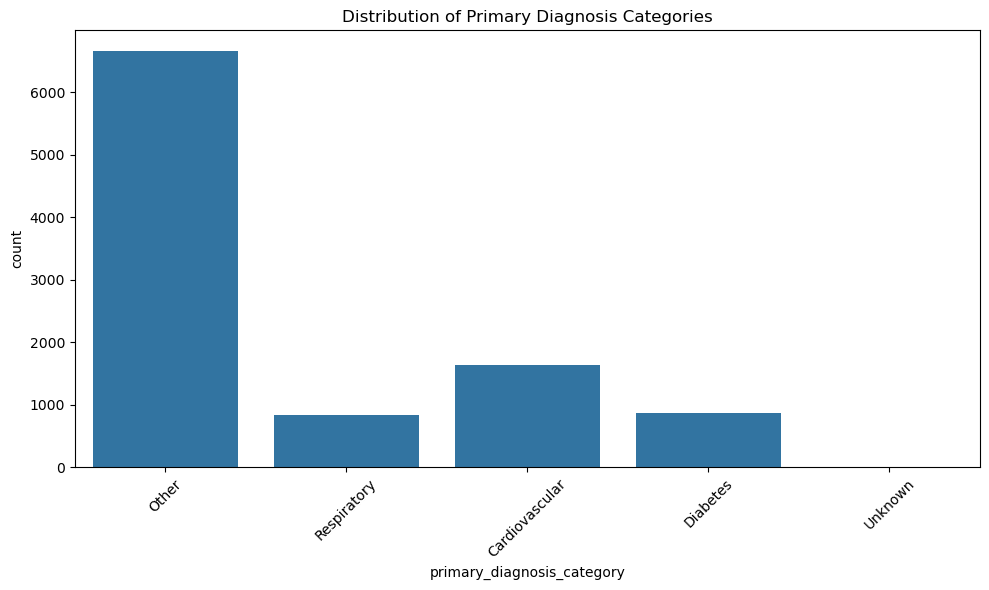

In [10]:
def categorize_diagnosis(diag_desc):
    if pd.isna(diag_desc):
        return 'Unknown'
    diag_lower = str(diag_desc).lower()
    if 'diabetes' in diag_lower:
        return 'Diabetes'
    elif any(x in diag_lower for x in ['heart', 'cardiac', 'coronary']):
        return 'Cardiovascular'
    elif any(x in diag_lower for x in ['respiratory', 'pneumonia', 'copd']):
        return 'Respiratory'
    else:
        return 'Other'

# Categorize and create dummy variables
df['primary_diagnosis_category'] = df['diag_1_desc'].apply(categorize_diagnosis)
diagnosis_dummies = pd.get_dummies(df['primary_diagnosis_category'], prefix='diag_cat')
df = pd.concat([df, diagnosis_dummies], axis=1)

# Visualize diagnosis distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='primary_diagnosis_category')
plt.xticks(rotation=45)
plt.title('Distribution of Primary Diagnosis Categories')
plt.tight_layout()
plt.show()

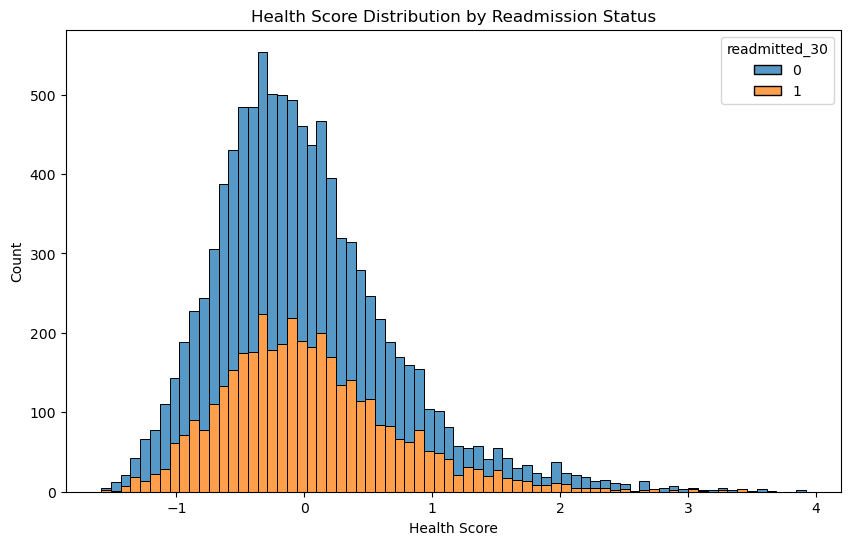


Available columns in the dataset:
['age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide.metformin', 'glipizide.metformin', 'glimepiride.pioglitazone', 'metformin.rosiglitazone', 'metformin.pioglitazone', 'change', 'diabetesMed', 'readmitted', 'diag_1_desc', 'diag_2_desc', 'diag_3_desc', 'age_numeric', 'readmitted_30', 'primary_diagnosis_category', 'diag_cat_Cardiovascular', 'diag_cat_Diabetes', 'diag_cat_Other', 'diag_cat_Respiratory', 'diag_cat_Unknown', 

In [11]:
# Create health score
numerical_cols = ['num_lab_procedures', 'num_procedures', 'num_medications']
scaler = StandardScaler()
normalized_vals = scaler.fit_transform(df[numerical_cols])
df['health_score'] = (normalized_vals[:, 0] * 0.3 + 
                     normalized_vals[:, 1] * 0.3 + 
                     normalized_vals[:, 2] * 0.4)

# Visualize health score
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='health_score', hue='readmitted_30', multiple="stack")
plt.title('Health Score Distribution by Readmission Status')
plt.xlabel('Health Score')
plt.ylabel('Count')
plt.show()

# Feature encodings
nominal_features = ['race', 'gender', 'medical_specialty']
for feature in nominal_features:
    dummies = pd.get_dummies(df[feature], prefix=feature)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(feature, axis=1)

ordinal_features = ['discharge_disposition_id', 'admission_source_id']
le = LabelEncoder()
for feature in ordinal_features:
    df[f'{feature}_encoded'] = le.fit_transform(df[feature].astype(str))

# Create interaction features
df['procedure_medication_interaction'] = df['num_procedures'] * df['num_medications']  # Changed from total_medications
df['lab_medication_interaction'] = df['num_lab_procedures'] * df['num_medications']  # Changed from total_medications

# Create complexity scores
df['medical_complexity'] = (
    df['num_lab_procedures'] * 0.4 +
    df['num_procedures'] * 0.3 +
    df['num_medications'] * 0.3 +  # Changed from total_medications
    (df['diag_cat_Diabetes'].fillna(0) * 0.2) +
    (df['diag_cat_Cardiovascular'].fillna(0) * 0.2)
)

df['diagnosis_severity'] = (
    (df['diag_cat_Diabetes'].fillna(0) * 3) +
    (df['diag_cat_Cardiovascular'].fillna(0) * 2) +
    (df['diag_cat_Respiratory'].fillna(0) * 2) +
    (df['diag_cat_Other'].fillna(0) * 1)
)

# Let's verify the columns we have
print("\nAvailable columns in the dataset:")
print(df.columns.tolist())

In [13]:
def prepare_modeling_features(df):
    """Prepare feature sets for modeling tasks"""
    
    common_features = [
        'age_numeric', 'time_in_hospital', 'num_lab_procedures',
        'num_procedures', 'num_medications', 'health_score',  # Changed from total_medications
        'medical_complexity', 'diagnosis_severity',
        'procedure_medication_interaction', 'lab_medication_interaction',
        'discharge_disposition_id_encoded', 'admission_source_id_encoded'
    ]
    
    # Get all dummy columns
    dummy_cols = [col for col in df.columns if any(x in col for x in 
                 ['diag_cat_', 'race_', 'gender_', 'medical_specialty_'])]
    
    # Combine features
    feature_cols = common_features + dummy_cols
    
    # Select only existing columns
    existing_cols = [col for col in feature_cols if col in df.columns]
    
    print(f"Total features selected: {len(existing_cols)}")
    return existing_cols

# Prepare features
selected_features = prepare_modeling_features(df)
X = df[selected_features]

# Prepare targets for both tasks
resource_targets = {
    'length_of_stay': df['time_in_hospital'],
    'num_procedures': df['num_procedures'],
    'num_medications': df['num_medications']  # Changed from total_medications
}
y_readmission = df['readmitted_30']

print("\nFeature shape:", X.shape)
print("Number of resource targets:", len(resource_targets))
print("Readmission target shape:", y_readmission.shape)


Total features selected: 78

Feature shape: (10000, 78)
Number of resource targets: 3
Readmission target shape: (10000,)


In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import MinMaxScaler

# Set random seed for reproducibility
tf.random.set_seed(42)

# Update resource optimization models
resource_models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'SVR': SVR(),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
    'TensorFlow': 'tensorflow'  # Placeholder for TensorFlow model
}

# Update readmission models
readmission_models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'TensorFlow': 'tensorflow'  # Placeholder for TensorFlow model
}

# Update parameter grids (remove Neural Network parameters as TensorFlow will be handled separately)
param_grid_resource = {
    'Random Forest': {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20]
    },
    'Linear Regression': {},
    'Ridge': {
        'alpha': [0.1, 1.0, 10.0]
    },
    'Lasso': {
        'alpha': [0.1, 1.0, 10.0]
    },
    'SVR': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'LightGBM': {
        'num_leaves': [31, 50],
        'learning_rate': [0.05, 0.1],
        'n_estimators': [50, 100]
    }
}

param_grid_readmission = {
    'Random Forest': {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'class_weight': ['balanced', None]
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'class_weight': ['balanced', None]
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'class_weight': ['balanced', None]
    },
    'XGBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6]
    },
    'LightGBM': {
        'num_leaves': [31, 50],
        'learning_rate': [0.05, 0.1],
        'n_estimators': [50, 100]
    }
}

# Define TensorFlow model architectures
def create_tf_regression_model(input_dim):
    """Create TensorFlow model for resource optimization"""
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_dim=input_dim),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)  # Output layer for regression
    ])
    
    model.compile(optimizer='adam',
                 loss='mse',
                 metrics=['mae'])
    return model

def create_tf_classification_model(input_dim):
    """Create TensorFlow model for readmission prediction"""
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_dim=input_dim),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

###  Training Resource Optimization Models:

In [27]:
# Function to train resource optimization models
def train_resource_models(X, y, target_name):
    print(f"\nTraining models for {target_name}")
    print("=" * 50)
    
    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    results = {}
    
    for name, model in resource_models.items():
        print(f"\nTraining {name}...")
        
        if name == 'TensorFlow':
            # Create and train TensorFlow model
            tf_model = create_tf_regression_model(X_train.shape[1])
            
            early_stopping = callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            )
            
            history = tf_model.fit(
                X_train_scaled, y_train,
                epochs=100,
                batch_size=32,
                validation_split=0.2,
                callbacks=[early_stopping],
                verbose=1
            )
            
            y_pred = tf_model.predict(X_test_scaled).flatten()
            results[name] = {
                'model': tf_model,
                'history': history.history,
                'predictions': y_pred
            }
            
        else:
            # Train traditional models
            if name in param_grid_resource:
                grid = GridSearchCV(
                    model,
                    param_grid_resource[name],
                    cv=5,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1
                )
                grid.fit(X_train_scaled, y_train)
                best_model = grid.best_estimator_
                print(f"Best parameters: {grid.best_params_}")
                y_pred = best_model.predict(X_test_scaled)
                results[name] = {
                    'model': best_model,
                    'predictions': y_pred
                }
            else:
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
                results[name] = {
                    'model': model,
                    'predictions': y_pred
                }
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        results[name].update({
            'mse': mse,
            'rmse': rmse,
            'r2': r2,
            'y_test': y_test
        })
        
        print(f"MSE: {mse:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"R2 Score: {r2:.4f}")
    
    return results

# Train models for each resource target
resource_targets = {
    'length_of_stay': df['time_in_hospital'],
    'num_procedures': df['num_procedures'],
    'num_medications': df['num_medications']
}

resource_results = {}
for target_name, y in resource_targets.items():
    resource_results[target_name] = train_resource_models(X, y, target_name)


Training models for length_of_stay

Training Random Forest...
Best parameters: {'max_depth': None, 'n_estimators': 50}
MSE: 0.0000
RMSE: 0.0000
R2 Score: 1.0000

Training Linear Regression...
Best parameters: {}
MSE: 0.0000
RMSE: 0.0000
R2 Score: 1.0000

Training Ridge...
Best parameters: {'alpha': 0.1}
MSE: 0.0000
RMSE: 0.0009
R2 Score: 1.0000

Training Lasso...
Best parameters: {'alpha': 0.1}
MSE: 0.1908
RMSE: 0.4369
R2 Score: 0.9795

Training SVR...
Best parameters: {'C': 0.1, 'kernel': 'linear'}
MSE: 0.0038
RMSE: 0.0619
R2 Score: 0.9996

Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1189
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 45
[LightGBM] [Info] Start training from score 4.416719
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.0

### Training Readmission Prevention Models

In [19]:
def train_readmission_models(X, y):
    print("\nTraining Readmission Prevention Models")
    print("=" * 50)
    
    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    results = {}
    
    for name, model in readmission_models.items():
        print(f"\nTraining {name}...")
        
        if name == 'TensorFlow':
            # Create and train TensorFlow model
            tf_model = create_tf_classification_model(X_train.shape[1])
            
            early_stopping = callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            )
            
            history = tf_model.fit(
                X_train_scaled, y_train,
                epochs=100,
                batch_size=32,
                validation_split=0.2,
                callbacks=[early_stopping],
                verbose=1
            )
            
            y_pred_proba = tf_model.predict(X_test_scaled).flatten()
            y_pred = (y_pred_proba > 0.5).astype(int)
            
            results[name] = {
                'model': tf_model,
                'history': history.history,
                'predictions': y_pred,
                'pred_proba': y_pred_proba
            }
            
        else:
            # Train traditional models
            if name in param_grid_readmission:
                grid = GridSearchCV(
                    model,
                    param_grid_readmission[name],
                    cv=5,
                    scoring='roc_auc',
                    n_jobs=-1
                )
                grid.fit(X_train_scaled, y_train)
                best_model = grid.best_estimator_
                print(f"Best parameters: {grid.best_params_}")
            else:
                best_model = model
                best_model.fit(X_train_scaled, y_train)
            
            y_pred = best_model.predict(X_test_scaled)
            y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
            
            results[name] = {
                'model': best_model,
                'predictions': y_pred,
                'pred_proba': y_pred_proba
            }
        
        # Calculate metrics
        results[name].update({
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred_proba),
            'y_test': y_test
        })
        
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        print(f"ROC-AUC Score: {results[name]['roc_auc']:.4f}")
    
    return results

# Train readmission models
readmission_results = train_readmission_models(X, y_readmission)


Training Readmission Prevention Models

Training Random Forest...
Best parameters: {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 150}

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.64      0.67      1207
           1       0.51      0.57      0.54       793

    accuracy                           0.62      2000
   macro avg       0.61      0.61      0.61      2000
weighted avg       0.62      0.62      0.62      2000

ROC-AUC Score: 0.6426

Training Logistic Regression...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Best parameters: {'C': 10, 'class_weight': 'balanced'}

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.56      0.62      1207
           1       0.48      0.62      0.54       793

    accuracy                           0.58      2000
   macro avg       0.58      0.59      0.58      2000
weighted avg       0.61      0.58      0.59      2000

ROC-AUC Score: 0.6072

Training SVC...
Best parameters: {'C': 1, 'class_weight': 'balanced', 'kernel': 'rbf'}

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.54      0.61      1207
           1       0.48      0.65      0.55       793

    accuracy                           0.58      2000
   macro avg       0.59      0.60      0.58      2000
weighted avg       0.61      0.58      0.59      2000

ROC-AUC Score: 0.6246

Training XGBoost...
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Classificati

### Visualization for Resource Optimization Results

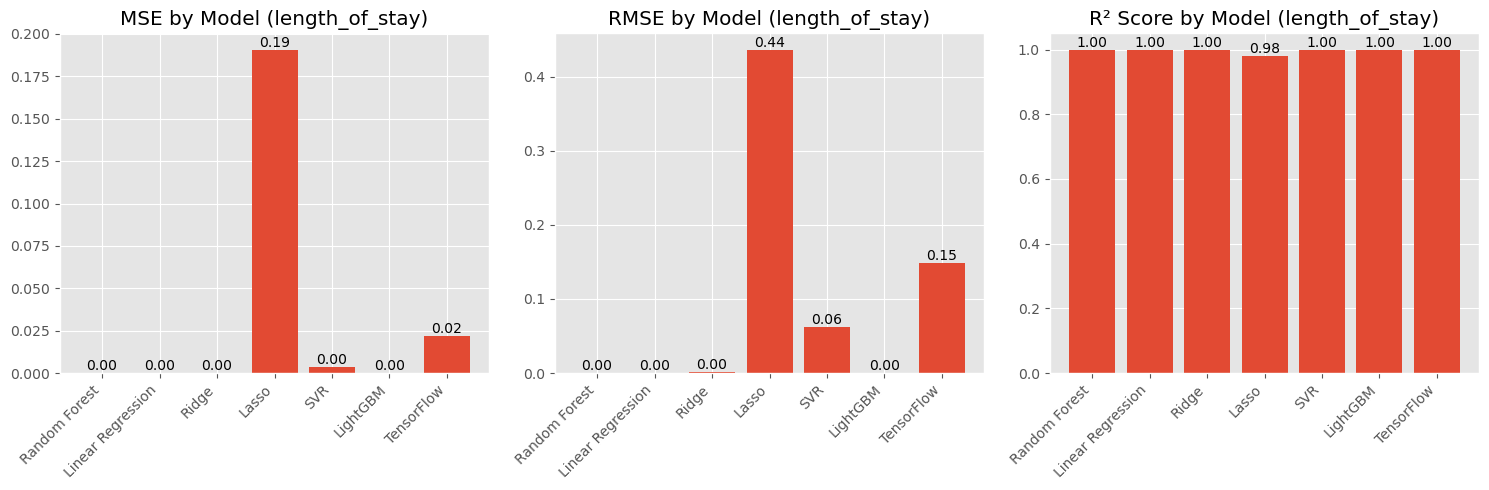

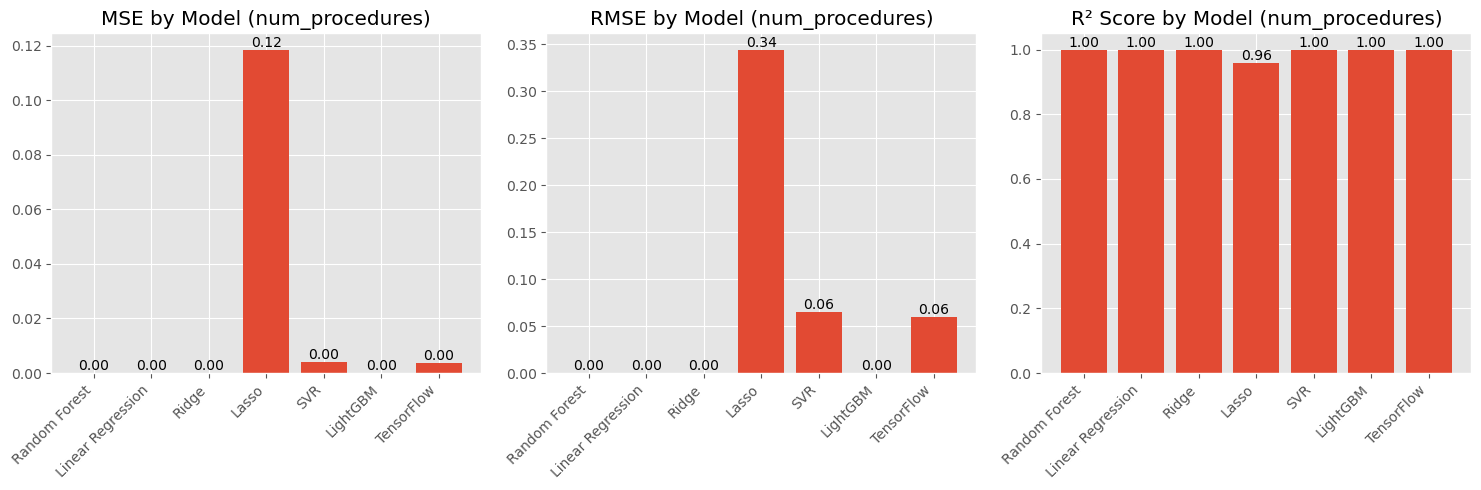

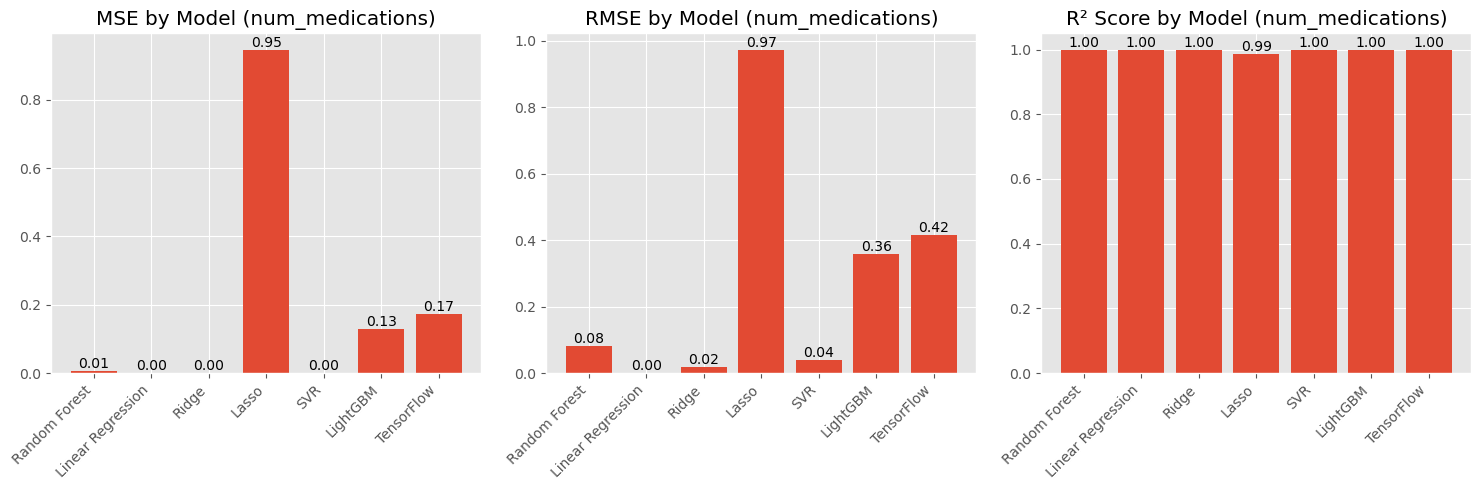

In [28]:
import matplotlib.pyplot as plt

# Set style
plt.style.use('ggplot')

# Plot results for each resource target
for target_name, results in resource_results.items():
    # Create figure for metrics
    plt.figure(figsize=(15, 5))
    
    # Plot MSE
    plt.subplot(1, 3, 1)
    mse_scores = [res['mse'] for res in results.values()]
    bars = plt.bar(results.keys(), mse_scores)
    plt.title(f'MSE by Model ({target_name})')
    plt.xticks(rotation=45, ha='right')
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{bar.get_height():.2f}',
                ha='center', va='bottom')
    
    # Plot RMSE
    plt.subplot(1, 3, 2)
    rmse_scores = [res['rmse'] for res in results.values()]
    bars = plt.bar(results.keys(), rmse_scores)
    plt.title(f'RMSE by Model ({target_name})')
    plt.xticks(rotation=45, ha='right')
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{bar.get_height():.2f}',
                ha='center', va='bottom')
    
    # Plot R2
    plt.subplot(1, 3, 3)
    r2_scores = [res['r2'] for res in results.values()]
    bars = plt.bar(results.keys(), r2_scores)
    plt.title(f'R² Score by Model ({target_name})')
    plt.xticks(rotation=45, ha='right')
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{bar.get_height():.2f}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

### Visualization for Readmission Prevention Results

In [30]:
from sklearn.metrics import roc_curve

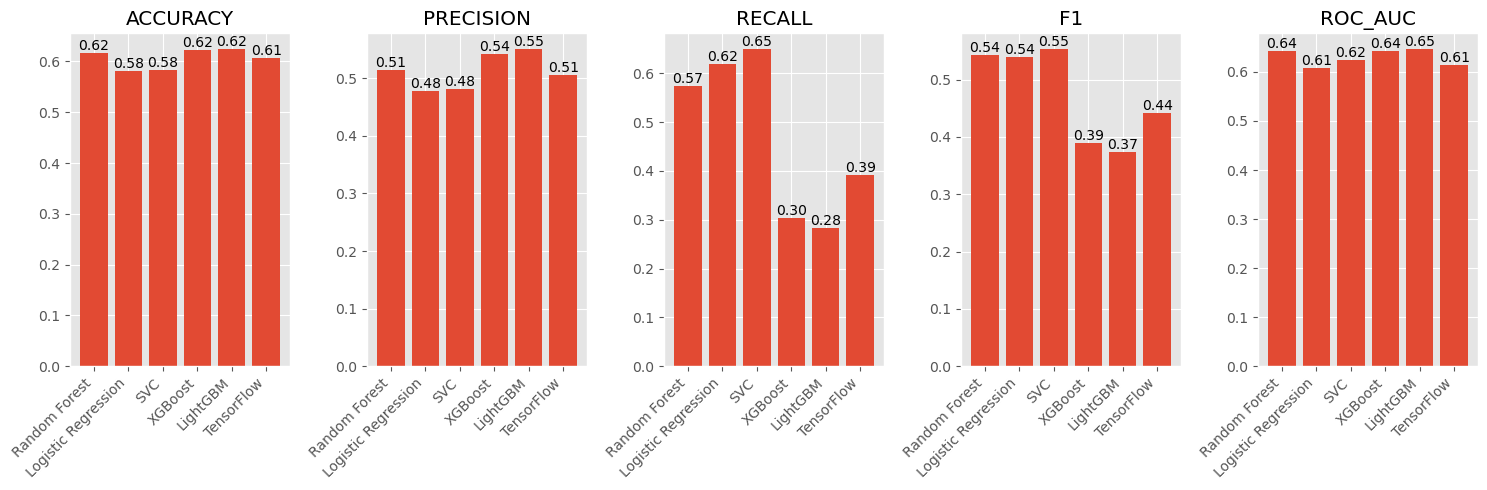

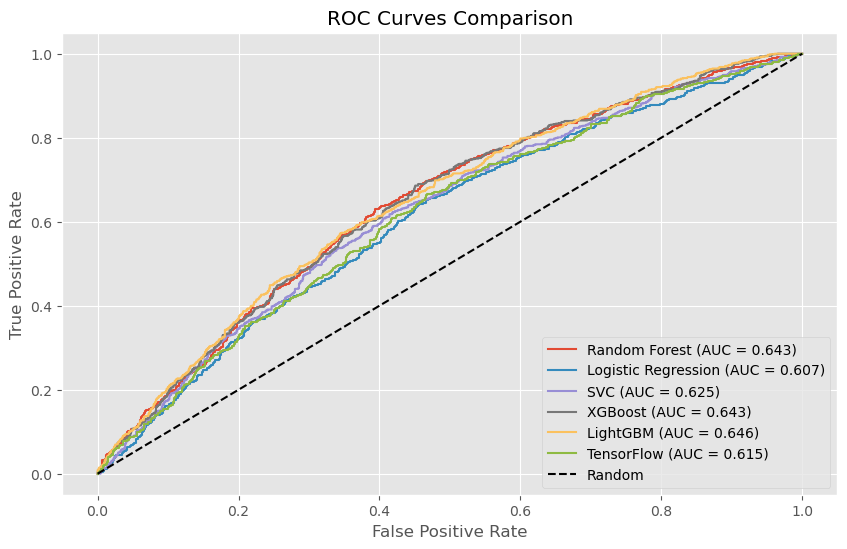

In [31]:
# Plot performance metrics
plt.figure(figsize=(15, 5))
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for i, metric in enumerate(metrics):
    plt.subplot(1, 5, i+1)
    scores = [results[metric] for results in readmission_results.values()]
    bars = plt.bar(readmission_results.keys(), scores)
    plt.title(f'{metric.upper()}')
    plt.xticks(rotation=45, ha='right')
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{bar.get_height():.2f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 6))
for name, results in readmission_results.items():
    fpr, tpr, _ = roc_curve(results['y_test'], results['pred_proba'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {results["roc_auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Model Summary and Recommendation

In [32]:
print("Model Performance Summary")
print("=" * 50)

# Resource Optimization Summary
print("\nResource Optimization Results:")
print("-" * 30)
for target_name, results in resource_results.items():
    print(f"\n{target_name}:")
    best_mse_model = min(results.items(), key=lambda x: x[1]['mse'])[0]
    best_r2_model = max(results.items(), key=lambda x: x[1]['r2'])[0]
    
    print(f"Best model by MSE: {best_mse_model} (MSE: {results[best_mse_model]['mse']:.4f})")
    print(f"Best model by R²: {best_r2_model} (R²: {results[best_r2_model]['r2']:.4f})")

# Readmission Prevention Summary
print("\nReadmission Prevention Results:")
print("-" * 30)
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
for metric in metrics:
    best_model = max(readmission_results.items(), key=lambda x: x[1][metric])[0]
    print(f"Best model by {metric}: {best_model} ({metric}: {readmission_results[best_model][metric]:.4f})")

# Overall Recommendations
print("\nRecommendations:")
print("-" * 30)

# Resource Optimization Recommendations
for target_name, results in resource_results.items():
    print(f"\nFor {target_name}:")
    best_overall = max(results.items(), key=lambda x: x[1]['r2'])[0]
    print(f"Recommended model: {best_overall}")
    print(f"R² Score: {results[best_overall]['r2']:.4f}")
    print(f"RMSE: {results[best_overall]['rmse']:.4f}")

# Readmission Prevention Recommendation
best_readmission = max(readmission_results.items(), 
                      key=lambda x: (x[1]['roc_auc'] + x[1]['f1']) / 2)[0]
print("\nFor Readmission Prevention:")
print(f"Recommended model: {best_readmission}")
print(f"ROC-AUC: {readmission_results[best_readmission]['roc_auc']:.4f}")
print(f"F1 Score: {readmission_results[best_readmission]['f1']:.4f}")

Model Performance Summary

Resource Optimization Results:
------------------------------

length_of_stay:
Best model by MSE: Random Forest (MSE: 0.0000)
Best model by R²: Random Forest (R²: 1.0000)

num_procedures:
Best model by MSE: Random Forest (MSE: 0.0000)
Best model by R²: Random Forest (R²: 1.0000)

num_medications:
Best model by MSE: Linear Regression (MSE: 0.0000)
Best model by R²: Linear Regression (R²: 1.0000)

Readmission Prevention Results:
------------------------------
Best model by accuracy: LightGBM (accuracy: 0.6240)
Best model by precision: LightGBM (precision: 0.5504)
Best model by recall: SVC (recall: 0.6494)
Best model by f1: SVC (f1: 0.5532)
Best model by roc_auc: LightGBM (roc_auc: 0.6463)

Recommendations:
------------------------------

For length_of_stay:
Recommended model: Random Forest
R² Score: 1.0000
RMSE: 0.0000

For num_procedures:
Recommended model: Random Forest
R² Score: 1.0000
RMSE: 0.0000

For num_medications:
Recommended model: Linear Regression
R

### readmission models  hyperparameter tuning

In [40]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import warnings

In [45]:
focused_param_grid = {
    'Random Forest': {
        'n_estimators': randint(100, 1000),
        'max_depth': [None] + list(range(10, 110, 10)),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'max_features': ['sqrt', 'log2', None],
        'class_weight': ['balanced', 'balanced_subsample', None]
    },
    'LightGBM': {
        'num_leaves': randint(20, 100),
        'learning_rate': uniform(0.01, 0.2),
        'n_estimators': randint(100, 1000),
        'min_child_samples': randint(10, 50),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'reg_alpha': uniform(0, 2),
        'reg_lambda': uniform(0, 2)
    },
    'XGBoost': {
        'n_estimators': randint(100, 1000),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 12),
        'min_child_weight': randint(1, 10),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'gamma': uniform(0, 2),
        'reg_alpha': uniform(0, 2),
        'reg_lambda': uniform(0, 2)
    }
}


In [46]:
def tune_models_simple(X, y, models_to_tune=['LightGBM', 'Random Forest', 'XGBoost']):
    """
    Simplified model tuning using RandomizedSearchCV
    """
    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    results = {}
    
    for model_name in models_to_tune:
        print(f"\nTuning {model_name}...")
        
        # Get base model
        base_model = readmission_models[model_name]
        
        # Perform RandomizedSearchCV
        random_search = RandomizedSearchCV(
            base_model,
            focused_param_grid[model_name],
            n_iter=50,
            scoring='roc_auc',
            cv=5,
            n_jobs=-1,
            random_state=42,
            verbose=2
        )
        
        # Fit the model
        random_search.fit(X_train_scaled, y_train)
        
        # Get best model
        best_model = random_search.best_estimator_
        
        # Make predictions
        y_pred = best_model.predict(X_test_scaled)
        y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
        
        # Store results
        results[model_name] = {
            'model': best_model,
            'best_params': random_search.best_params_,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred_proba),
            'predictions': y_pred,
            'pred_proba': y_pred_proba,
            'y_test': y_test
        }
        
        print(f"\nBest parameters for {model_name}:")
        print(random_search.best_params_)
        print(f"\nResults for tuned {model_name}:")
        print(f"ROC-AUC: {results[model_name]['roc_auc']:.4f}")
        print(f"Accuracy: {results[model_name]['accuracy']:.4f}")
        print(f"F1 Score: {results[model_name]['f1']:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
    
    return results

In [47]:
# Function to visualize results
def plot_tuning_comparison(original_results, tuned_results):
    """Plot comparison of original and tuned models"""
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    models = list(tuned_results.keys())
    
    fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 4*len(metrics)))
    width = 0.35
    
    for i, metric in enumerate(metrics):
        original_scores = [original_results[model][metric] for model in models]
        tuned_scores = [tuned_results[model][metric] for model in models]
        
        x = np.arange(len(models))
        axes[i].bar(x - width/2, original_scores, width, label='Original', color='lightblue')
        axes[i].bar(x + width/2, tuned_scores, width, label='Tuned', color='lightgreen')
        
        axes[i].set_title(f'{metric.upper()} Comparison')
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(models, rotation=45)
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for j, v in enumerate(original_scores):
            axes[i].text(j - width/2, v, f'{v:.3f}', ha='center', va='bottom')
        for j, v in enumerate(tuned_scores):
            axes[i].text(j + width/2, v, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()




Tuning LightGBM...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 2537, number of negative: 3863
[LightGBM] [Info] Number of positive: 2538, number of negative: 3862
[LightGBM] [Info] Number of positive: 2538, number of negative: 3862[LightGBM] [Info] Number of positive: 2538, number of negative: 3862[LightGBM] [Info] Number of positive: 2537, number of negative: 3863[LightGBM] [Info] Number of positive: 2537, number of negative: 3863

[LightGBM] [Info] Number of positive: 2538, number of negative: 3862


[LightGBM] [Info] Number of positive: 2538, number of negative: 3862
[LightGBM] [Info] Number of positive: 2538, number of negative: 3862
[LightGBM] [Info] Number of positive: 2538, number of negative: 3862
[LightGBM] [Info] Number of positive: 2537, number of negative: 3863
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009144 seconds.
You can set `force_row_wise=true` to remove the overhea

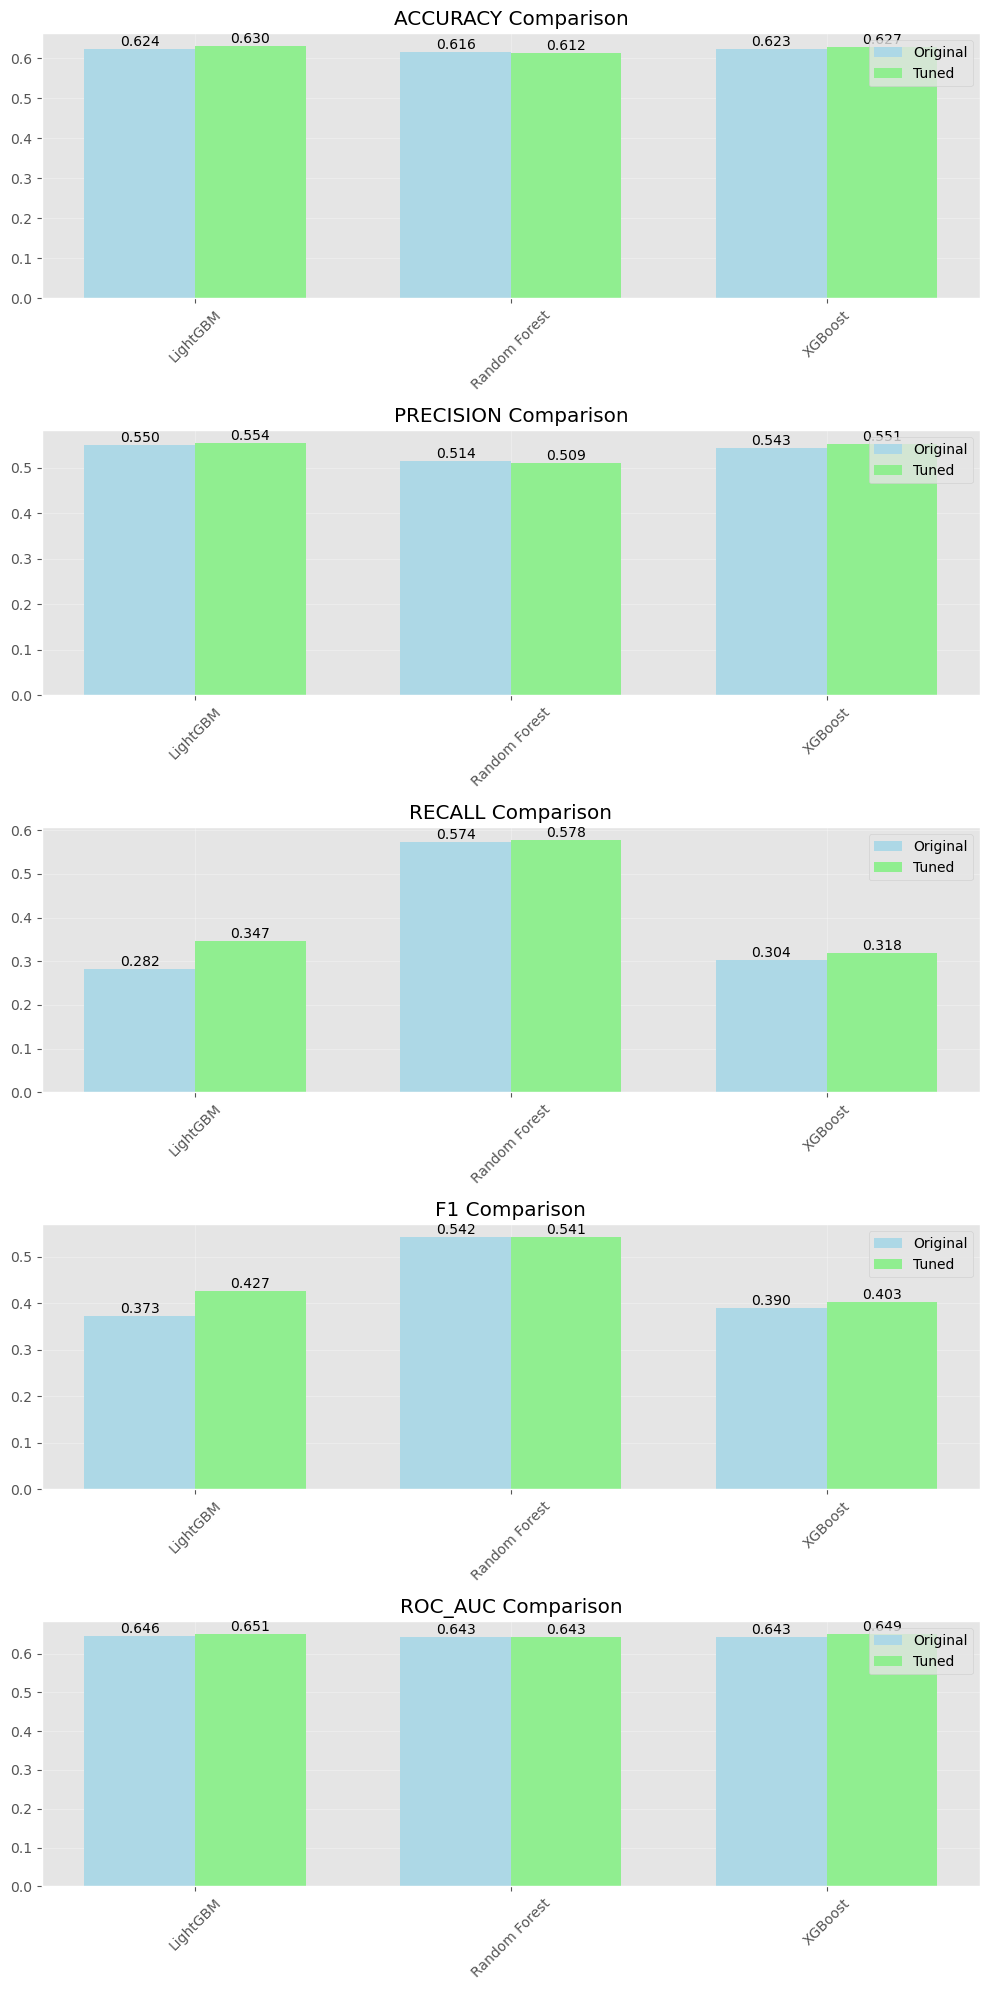

In [48]:

original_results = {k: v for k, v in readmission_results.items() 
                   if k in ['LightGBM', 'Random Forest', 'XGBoost']}

# Tuning process
tuned_results = tune_models_simple(X, y_readmission)

# Visualize the improvements
plot_tuning_comparison(original_results, tuned_results)